<h3> CS4619 Assignment</h3>
<p> Dlo Bagari - 114702261</p>

In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [46]:
def plot_loss(history):
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    x_vals = range(1, len(train_loss) + 1)
    fig = plt.figure()
    plt.title("Loss")
    plt.plot(x_vals, train_loss, label="Training loss", color = "purple")
    plt.plot(x_vals, val_loss, label="Validation loss", color = "orange")
    plt.legend()
    plt.show()
    
def plot_accuracy(history):
    train_acc = history.history["acc"]
    val_acc = history.history["val_acc"]
    x_vals = range(1, len(train_acc) + 1)
    fig = plt.figure()
    plt.title("Accuracy")
    plt.plot(x_vals, train_acc, label="Training accuracy", color = "purple")
    plt.plot(x_vals, val_acc, label="Validation accuracy", color = "orange")
    plt.legend()
    plt.show()

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l1
from keras.regularizers import l2
from random import randint
import os
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.layers import BatchNormalization
import shutil

<h5> Splitting Data</h5>

<p>Our data is separated into three separate folders(training data, evaluation data, testing data), each folder contains a subdirectory for each category, and each category contains all images related to class. With this special structure and some tools from keras library, we can easily efficiently import images. before we import images and build a Convolutional Neural Network, we will analyze our data to obtain more information about our data.</p>

In [48]:
base_dir = "datasets/dataset_signs"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")
batch_size = 16
nb_epoch = 30
learning_rate = 0.001

<h5>Analyzing training Data</h5/>

<p>First, we will look at the number of images in each category, and see if there is a balance between
all categories in term of number of images in each category.</p>

In [49]:
categories_dir = os.listdir(train_dir)
categories = {}
for category in categories_dir:
    categories[int(category)] = len(os.listdir(train_dir +"/"+ category))
categories_list = list(categories.keys())
values = list(categories.values())
max_value = max(values)

In [50]:
# create a barchart to represent the number of images in each category
def show_data(categories, values, message):
    plt.figure(figsize=(8, 4))
    plt.bar(categories, values, align='center')
    plt.ylabel('Number of images')
    plt.xlabel('categories')
    plt.title(message)
    plt.show()

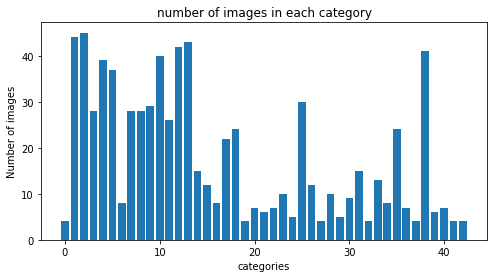

In [51]:
show_data(categories_list, values, "number of images in each category")

<p>The above Barchart shows there is no balance between the number of images in each category, this may effect the
network performance.</P>

<h5>Data Preprocessing</h5>

<p> we have 43 categories, images in these categories need to preprocess before we train our network with them,
we will apply the following preprocessing operations on each image:
<ul>
  <li>convert RGB values to float in [0, 1]</li>
  <li>resize image to 28x28 pixel</li>
  <li>Encode the class labels appropriately</li>
  <li>generate more data from the existing data(data augmentation) to reduce overfitting</li>
  <li>create min-batch of size 16 </li>
</ul>
keras library has a tool called ImageDataGenerator, which do all above preprocessing operations.</p>

In [52]:
def data_prep(batch_size, train_dir, val_dir, test_dir):
    train_data_generator = ImageDataGenerator(rescale=1./255,  
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            zoom_range=0.2,
                            rotation_range=5.0, fill_mode="nearest",
                            shear_range=0.2)
    train_generator = train_data_generator.flow_from_directory(train_dir, target_size=(28, 28),
                                                           batch_size=batch_size, class_mode="binary")
    val_data_generator = ImageDataGenerator(rescale=1./255)
    val_generator = val_data_generator.flow_from_directory(val_dir, target_size=(28, 28),
                                                       batch_size=batch_size, class_mode="binary")
    test_data_generator = ImageDataGenerator(rescale=1./255)
    test_generator = test_data_generator.flow_from_directory(test_dir, target_size=(28 ,28),
                                                         batch_size=batch_size, class_mode="binary")
    return (train_generator, val_generator, test_generator)

<h4> building Convolutional Neural Network </h4>

<p> Tuning a  Neural Network model to search for patterns in a set of data, depends on the structure of the data.
We use Deep learning networks to train a machine, to build its algorithm to detect a pattern in a given data.
We can configure a neural network in two ways, a sequence oflayers or as a graph. CNN layers are connected 
sequentially, and for this reason, we will configure our Deep learning network as sequential layer network.<p>
<p>
<p>First step in our network is to configure how our model will search and extract patterns from the input data,
and since our input data are images, and images are in two dimensions, we will configure our convolutional layers
as Convolution 2D layer. After one of several Convolution 2D layers, we will configure our model to apply a pooling
operation on the Convolution 2D layers results. We will use Max pooling to reduce the size of the Convolution 2D layers
results without losing the information related to the patterns. And before we fit MaxPooling results into a 
sequence of the fully connected layer, we will convert MaxPooling results into one large vector. The following steps are the steps for building process of our CNN:
<ul>
  <li>step 1 - Convolution: Convolution is a combine integration of two functions, and show how one function modify the shape of another
function. Convolution can be used to represent many types of image operations. We will use convolution for filtering
the input images and extract features from them. After converting input images to a matrix of pixel values, we will
apply 32 feature detector on that matrix, and the result of this operation will be 32 feature maps. the highest
number in a feature map represent here a feature detector detected a specific feature</li>
  <li>Step 2 - Max Pooling: Add a max pooling layer to reduce the size of feature maps to half, which will reduce the size of the input vector when we flatten it. And that vector will contain only information about the highly detected features in the input image. With having a small input vector, we can reduce the complexity in our network without reducing its performance. If we do not use a max pooling layer and we directly flat the feature maps into one single vector, then each number in that vector will represent an independent pixel. We want each number in the vector to represent the relationship of the pixel with the pixels around it, represent one specific feature, and that what max pooling and flatten will offer our network.
  </li>
  <li>Step 3 - Flattening: Add a Flattening layer which will take all pooled feature maps and convert them into one single vector, and this vector will be the input for the first hidden layer in fully connected layers.
In this stage, we convert the input image to a one-dimensional array, and now our model is ready to learn how
to classify the input image.</li>
   <li>Step 4 - Full Connection: Add a sequance of fully connected Layers to our network</li>
    <li>Step 5 - output layer: Add the output layer with softmax activiation function. with Softmax activiation the summation of all output will be equal to 1.0 always.</li>
</ul>  
</p>

In [53]:
def network_conf():
    model = Sequential()
    # add first convolutional layer, windows size = (3, 3),
    # activation function = ReLU, to remove negetive pixels in order to have non-lenearitly in our model
    # expected input shape(28, 28, 3)
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 3)))
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu" ))
    model.add(Dense(512, activation="relu" ))
    model.add(Dense(43, activation="softmax"))
    return model

<p>at this stage we have configured all layers in our network, next we will compile our network and specify what 
Stochastic Gradient Descent algorithm to use, what loss function, and what matrix parameter for performance matrix.</p>

In [54]:
model = network_conf()
model.compile(optimizer=RMSprop(lr=learning_rate), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [55]:
train_data, val_data, test_data = data_prep(batch_size, train_dir, val_dir, test_dir)

Found 768 images belonging to 43 classes.
Found 261 images belonging to 43 classes.
Found 278 images belonging to 43 classes.


In [56]:
#train the network 
history = model.fit_generator(train_data, steps_per_epoch=48, epochs=30, 
                    validation_data=val_data, validation_steps=16,
                              callbacks=[EarlyStopping(monitor="val_loss", patience=1)], verbose=0)

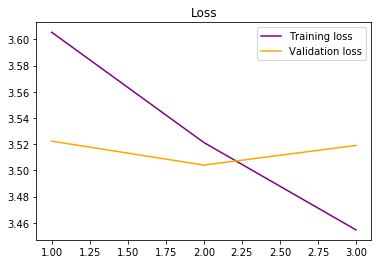

In [57]:
#plot the training loss and the validation loss
plot_loss(history)

<p>from above diagram we can the training loss is decreasing well, but validation loss is moving up and down.
Since we are using patience = 1, the training process is stopped once the validation loss is increased.
We will add dropout layers to our network, which will disactive some neurons after fitting one min-bach to
the network, and let the active neurons to layer about next min-batch. with dropout, almost all neurons will get
the same experience from the input data, and also it will reduce the overfitting.</p>

In [58]:
def networkConfWithDO():
    model = Sequential()
    # add first convolutional layer, windows size = (3, 3),
    # activation function = ReLU, to remove negetive pixels in order to have non-lenearitly in our model
    # expected input shape(28, 28, 3)
    model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 3)))
    model.add(Conv2D(32, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(512, activation="relu" ))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation="relu" ))
    model.add(Dense(43, activation="softmax"))
    return model

In [59]:
model = networkConfWithDO()
model.compile(optimizer=RMSprop(lr=learning_rate), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [60]:
#train the network 
history = model.fit_generator(train_data, steps_per_epoch=48, epochs=30, 
                    validation_data=val_data, validation_steps=16,
                              callbacks=[EarlyStopping(monitor="val_loss", patience=1)], verbose=0)

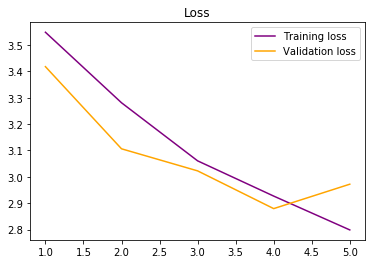

In [61]:
#plot the training loss and the validation loss
plot_loss(history)

<p> the performance of the network has been improved a bit. to keep validation loss decreasing slowly, we will
decrease the learning rate within each epoch. this will slow down the training process, but it could lead the
Gradient descent to the global minimum.</p> 

In [62]:
#decrease learning rate by   in each epoch
def learningRateScheduler(epoch):
    return 0.001* 1/(1 + 0.1 * epoch)  

In [63]:
model = networkConfWithDO()
model.compile(optimizer=RMSprop(lr=learning_rate), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [64]:
#train the network 
history = model.fit_generator(train_data, steps_per_epoch=48, epochs=30, 
                    validation_data=val_data, validation_steps=16,
                              callbacks=[EarlyStopping(monitor="val_loss", patience=1),
                                         LearningRateScheduler(learningRateScheduler)], verbose=0)

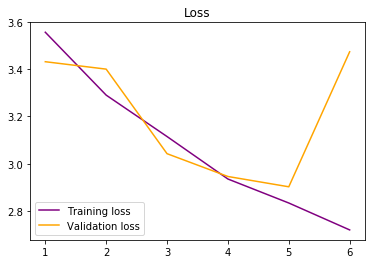

In [65]:
#plot the training loss and the validation loss
plot_loss(history)

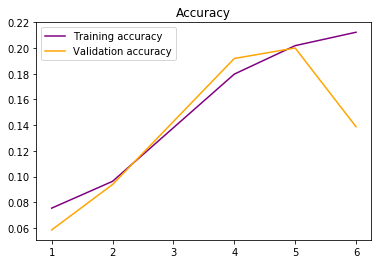

In [66]:
plot_accuracy(history)

<p>finally we train our network with train data and validation data and test it with test data, we will join all images in train folder and validation folder into one folder, and
do the final training</p>

In [67]:
os.mkdir("datasets/dataset_signs/temp")
shutil.copytree("datasets/dataset_signs/train","datasets/dataset_signs/temp/train" )
for file in os.listdir("datasets/dataset_signs/val"):
    images = os.listdir("datasets/dataset_signs/val/"+file)
    for img in images:
        shutil.copy("datasets/dataset_signs/val/{}/{}".format(file, img),
                   "datasets/dataset_signs/temp/train/"+file)
    

In [68]:
train_data, val_data, test_data = data_prep(batch_size,
                                            "datasets/dataset_signs/temp/train", val_dir, test_dir)

Found 1029 images belonging to 43 classes.
Found 261 images belonging to 43 classes.
Found 278 images belonging to 43 classes.


In [69]:
model = networkConfWithDO()
model.compile(optimizer=RMSprop(lr=learning_rate), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#train the network 
history = model.fit_generator(train_data, steps_per_epoch=64, epochs=30, 
                    validation_data=test_data, validation_steps=18,
                              callbacks=[EarlyStopping(monitor="val_loss", patience=1),
                                         LearningRateScheduler(learningRateScheduler)], verbose=0)

In [70]:
shutil.rmtree("datasets/dataset_signs/temp")

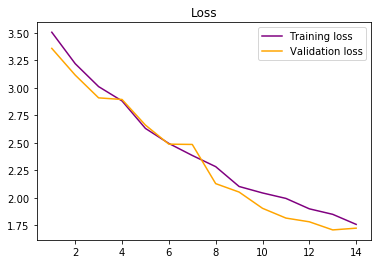

In [71]:
plot_loss(history)

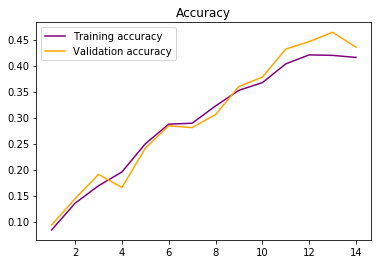

In [72]:
plot_accuracy(history)